*Autor: Manuel Torres V. 2021-2*
# Documentación del notebook: 
A continuación se presenta la lista de funciones presentes en este notebook, el detalle y la descripcion de cada una la puede encontrar en su respectivo contrato.

**Funciones de la parte 3:**
```
1) EstadoInicial()
2) DeltaH()
3) Ising()
```
**Funciones de la parte 5:**
```
1) GraficarSpinMedio()
```
**Funciones de la parte 6:**
```
1) GraficarSpinMedioFinoConZoom()
```

In [ ]:
# Librerias necesarias para correr el notebook
import numpy as np
from numpy import random as rn
import scipy as sp
import time
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
# Estilo de las figuras
sb.set_theme(style="dark")
sb.set_palette('tab10')

# Pregunta 1 - Modelo de Ising en $\mathbb{Z}^{2}$

Queremos modelar el ferromagnetismo  placa metálica plana idealizada. Específicamente para $N\in\mathbb{N}$ (grande), las moléculas de la placa se ubican en la grilla 2-dimensional $\Lambda = \Lambda_{N} = \{-N,\dots,N\}^{2} \subseteq \mathbb{Z}^{2}$, y  cada molécula posee un momento magnético o *spin*, el cual puede estar orientado hacia arriba o hacia abajo. 

Por lo tanto, el conjunto de posibles configuraciones es $E_{N} = \{-1,1\}^{\Lambda}$. Dado $x\in E_{N}$, y $m\in\Lambda$, denotamos $x(m) \in \{-1,1\}$ el spin del sitio $m$ en la configuración $x$. Trabajaremos en el espacio $E$ de configuraciones con spin fijo hacia arriba en el borde:

\begin{equation}
    E =\{x\in E_{N} : x(m)=1,\forall x(m) = 1, \forall m \in \partial\Lambda\},\text{ donde }\partial\Lambda = \Lambda_{N}\setminus\Lambda_{N-1}.
\end{equation}

En un material ferromagnético, los spins de sitios cercanos tienen tendencia a alinearse; es decir, spins iguales en sitios contiguos tienen asociada menor energía. Específicamente, la energía de una configuración $x\in E_{N}$ viene dada por
\begin{equation}
    H(x) = \sum_{m\sim m'}(x(m)-x(m'))^{2},
\end{equation}
donde $m\sim m'$ denota que $m$ y $m'$ son vecinos en la grilla, es decir, que están a distancia $1$ (cada par $m,m'\in\Lambda$ aparece una sola vez en la sumatoria). Supondremos que la probabilidad de que el sistema se encuentre en la configuración $x\in E$ está dada por 
\begin{equation}
    \pi_{x} = \frac{ e^{-\beta H(x)} }{ Z(\beta) },
\end{equation}
para $\beta > 0 $ dado ($1/\beta$ es la temperatura), y 
\begin{equation}
    Z(\beta) = \sum_{y\in E} e^{-\beta H(y)}
\end{equation}
es la constante de normalización. Observe que lo anterior hace improbables las configuraciones con mayor energía, lo cual es consecuente con lo que ocurre en los sistemas físicos. Se desea simular realizaciones de la distribución $\pi\in\mathcal{P}(E)$.



---



## Parte 1

### Enunciado 

Calcule $|E|$. Argumente por qué es imposible en la práctica calcular $Z(\beta)$ explícitamente, incluso para $N$ pequeño (por ejemplo $N = 10$).

### Solución

**Cardinal de $E$:** El borde de la grilla (la cantidad de elementos menos la cantidad de elementos del borde) de la grilla cuadrada de $n\times n$ corresponde a
\begin{equation}
    n^{2} - 4(n-1) = (n-2)^{2},
\end{equation}
por lo tanto, tener una grilla sobre $\{-N,\dots,N\}^{2}\subseteq\mathbb{Z}^{2}$, resulta en $n = 2N+1$ y como en cada celda de la grilla hay dos posibles opciones sigue que
\begin{eqnarray}
    |E| = 2^{(2N-1)^{2}}.
\end{eqnarray}

**Cálculo de $Z(\beta)$:** Para calcular $Z(\beta)$ se requiere realizar la suma de $|E|$ elementos. De lo anterior sigue que para $N = 10$ (pequeño) hay que realizar la suma de $2^{2(10-1)^{2}} = 2^{162}$ elementos, pues $Z(\beta)$ es
\begin{equation}
    Z(\beta) = \sum_{y \in E} e^{-\beta H(y)}.
\end{equation}
Por lo tanto no es posible calcular $Z(\beta)$, incluso para $N$ pequeño. Veamos a continuación un ejemplo, para ello calculamos el tiempo que demora la realización de una suma simple usando la librería *time*.

In [ ]:
start = time.perf_counter()     # Iniciamos el conteo
1+1                             # Hacemos una suma simple
end = time.perf_counter()       # Finalizamos el conteo
print(end - start)              # Print la diferencia de tiempo

6.454200047301129e-05


Según lo anterior, suponiendo que una suma demora un tiempo en el orden de $10^{-5}[s]$, para la suma con $N = 10$ hay que realizar $\sim 2^{162}$ sumas, que en distintas unidades me medida cotidianas es
\begin{equation}
   t_{suma}(N=10) = 5.846 \times 10^{43}[s] = 1.629 \times 10^{40}[hr] = 6.766 \times 10^{38} [dia].
\end{equation}

Para tener un marco de referencia, una persona en su vigésimo cumpleaños ha vivido aproximadamente 7300 días.

---

## Parte 2

### Enunciado
Consideremos el grafo $G$ sobre $E$ en el cual $xy$ es una arista de $G$ ssi $x$ e $y$ difieren en exactamente un sitio, es decir, ssi
\begin{equation}
    (\exists m_{0} \in\Lambda\setminus\partial\Lambda):\quad x(m_{0}) = -y(m_{0}),
\end{equation}
y además
\begin{equation}
    (\forall m \neq m_{0}),\quad x(m) = y(m).
\end{equation}

Escriba la matriz estocástica $R$ asociada a este grafo para el algoritmo de *Metrópolis* y de *Gibbs*. Obtenga una expreción explícita para
\begin{equation}
    \frac{ \pi_{y}R_{yx} }{ \pi_{x}R_{xy} }
\end{equation}
en ambos casos ¿Cuál algoritmo es más conveniente usar y por qué?

### Solución


1.   **Algoritmo de Gibbs:** Dados $x,y \in E$, sigue que tenemos la matriz estocástica
\begin{eqnarray*}
    R_{xy} = 
    \begin{cases}
        \dfrac{ e^{-\beta H(x)} }{ \displaystyle\sum_{z\sim x} e^{-\beta H(z)} },&x\sim y,\\
        0,&x\not\sim y.
    \end{cases}
\end{eqnarray*}
Por lo tanto, escribimos $(\pi_{y} R_{yx}) / (\pi_{x} R_{xy})$ en término de las expresiones anteriores,
\begin{eqnarray*}
    \frac{\pi_{y}R_{yx}}{\pi_{x}R_{xy}} = \frac{ \displaystyle\sum_{z \sim y} e^{-\beta H(z)} }{ \displaystyle\sum_{z \sim x} e^{-\beta H(z)} }
\end{eqnarray*}


2.   **Algoritmo de Metrópolis:** Considerando que para cualquier $x\in E$, tal que $\text{len}(x) = n$, se tiene que $\text{deg}(x) = (n-2)^{2}$, pues es la cantidad de matrices tal que difieren en un solo punto conrespecto a $x$, pues el borde está fijo. Así, tenemos la matriz estocástica
\begin{eqnarray*}
    R_{xy} =
    \begin{cases}
        \frac{1}{(n-2)^{2}},&x \sim y,\\
        0,                  &x \not\sim y.
    \end{cases}
\end{eqnarray*} 
Por lo tanto, escribimos $(\pi_{y} R_{yx}) / (\pi_{x} R_{xy})$ en término de las expresiones anteriores,
\begin{equation}
    \frac{\pi_{y}R_{yx}}{\pi_{x}R_{xy}} = \frac{\pi_{y}}{\pi_{x}} = \frac{ \frac{ e^{-\beta H(y)} }{ Z(\beta) } }{ \frac{ e^{-\beta H(x)} }{ Z(\beta) } } = e^{-\beta(H(y)-H(x))}.
\end{equation}

3.    **Diferencia de energía:** Notemos que la expresión $H(y)-H(x)$ se puede simplificar ya que tan solo se consideran los vecinos inmediatos de la posición $m\in\Lambda$, quedando tan solo $4$ sumandos,
\begin{eqnarray*}
    \Delta H 
    &=&    \sum_{m \sim m'} (y(m) - y(m'))^{2} - \sum_{m \sim m'} (x(m) - x(m'))^{2}\\    
    \text{(Consideramos $m = m_{ij}$)}
    &=&    4x(m_{i,j})[x(m_{i-1,j}) + x(m_{i+1,j}) + x(m_{i,j-1}) + x(m_{i,j+1})]
\end{eqnarray*}
Por lo tanto, notemos que para el cálculo de $\frac{\pi_{y}R_{yx}}{\pi_{x}R_{xy}}$, el *algoritmo de Gibbs* requiere una mayor cantidad de cálculos que el *algoritmo de Metrópolis*, siendo así el segundo la mejor opción.

---


## Parte 3
### Enunciado
Describa el algoritmo MCMC correspondiente a este caso usando *pseudo-código*. En base a él, programe un método *X=Ising(N,beta,nf)* que simule *nf* pasos de la cadena, grafique su estado cada cierta cantidad de pasos (mostrando la grilla $\Lambda$ y asociando un color al spin $-1$ y otro a $1$), y retorne el estado final $X$, en caso que *nf* sea finito. Escoja los spins iniciales independientes con ley $2\cdot\text{Bernoulli}(p) - 1$, para algún $p\in(1/2,1)$. Haga esto para $2$ valores de $p$ distintitvos. Comente la diferencia o similitud observadas entre ambos casos y la relevancia de dicha elección. Fije un valor para todo lo que viene.

### Solución

**Pseudocódigo de Ising:** El algoritmo de MCMC que usaremos usa el resultado obtenido para el *Algoritmo de Metrópolis* usando 
\begin{equation}
    R = e^{-\beta(H(y)-H(x))}.
\end{equation}
Para el siguiente algoritmo sean $(U_{n})_{n\in\mathbb{N}}$ y $(V_{n})_{n\in\mathbb{N}}$ secuencias de variables aleatorias i.i.d. de distribución $U([0,1])$, y $f$ la función de transición asociada a $R$. Sean $\mu$ una distribución inicial tal que los spins distribuyen con ley $2\cdot\text{Bernoilli}(p) - 1$ que está sujeta a la condición de borde, esto es que $x(m) = 1$ para todo $m\in\partial\Lambda$.
```
# Pseudo código de Ising(N, beta , nf):
Ising(N , beta , nf):
    # Inicializa asignando una distribucion inicial, fijando las condiciones
    # en el forme, esto esq que el spin toma orientacion 1 en \partial\Lambda.
    X_0 = mu                 
    for i = 0 to nf-1 do     # Estudiamos nf pasos de la cadena
        u = U([0,1])         # Asignar simulaciones de uniformes(0,1)
        v = U([0,1])         # Asignar simulaciones de uniformes(0,1)
        y = f(v,x)           # Asignar segun la funcion de transicion (a matriz R)
        if u <= alpha:       # Actualizar estado al siguiente paso
            x(i+1) = y       
        else:                # Mantener estado al siguiente paso
            x(i+1) = x(i)
    fin
fin
```
**Código:** A continuación implementamos el código, para ello usamos dos métodos auxiliares, el primero es *EstadoInicial* que calcula un estado para $X_{0}$ respetando las condiciones de borde, el segundo es *DeltaH* que calcula el término $H(y)-H(x)$ según las $4$ sumas vistas en la parte anterior.

In [ ]:
def EstadoInicial(N, p):
    """=========================================================================
    INPUT: El metodo recibe los siguientes parametros
    N = largo de la grilla
    p = parametro de la ley
    ---
    OUTPUT: El metodo retorna una matriz de (2N+1,2N+1) determinando un estado
    inicial para el sistema.
    ---
    COMENTARIOS: Ninguno
    ========================================================================="""
    n = 2*N + 1                     # Tamaño de la grilla (desde -N hasta N)
    X_0 = np.ones((n, n))           # Matriz con estados iniciales
    for i in range(1, n-1):         # Recorre las filas
        for j in range(1, n-1):     # Recorre las columnas
            X_0[i,j] = 2*np.random.binomial(1, p) - 1
    output = X_0
    return output
def DeltaH(X, i, j):
    """=========================================================================
    INPUT: El metodo recibe los siguientes parametros
    x = matriz
    (i,j) = posicion en la grilla
    ---
    OUTPUT: El metodo retorna el calculo de H(y) - H(x) necesarios para el
    calculo de alpha en el algoritmo de metropolis
    ---
    COMENTARIOS: Ninguno
    ========================================================================="""
    output = X[i,j] * 4 * (X[i-1,j] + X[i+1,j] + X[i,j-1] + X[i,j+1])
    return output
def Ising(N, beta, nf, p, grafico=False):
    """=========================================================================
    INPUT: El metodo recibe los siguientes parametros
    N = largo de la grilla
    beta = beta dado, corresponde al inverso de la temperatura
    nf = cantidad de pasos de la cadena de Markov
    p = parametro en la distribucion 2Bernoulli(p)-1
    grafico = por default este parametro es False, en caso de autorizar (True)
    entregara la figura de la grilla cada 1000 pasos de la cadena de Markov
    ---
    OUTPUT: [ X, np.sum(X)/len(X)**2 ] (Estado final, spin medio que sirve para
    mas adelante en las partes 5 y 6)
    ---
    COMENTARIOS: Ver pseudocodigo descrito. El metodo ademas grafica en el 
    proceso, pero el plot no es parte del return (cuidado en eso)
    ========================================================================="""
    X = EstadoInicial(N,p)
    n = len(X)
    for k in range(nf):
        u = rn.uniform()
        i = rn.randint(1,n-1)
        j = rn.randint(1,n-1)
        if u <= np.exp(-beta * DeltaH(X, i, j)):
            Y = np.array(X)
            Y[i,j] = -Y[i,j]
            X = Y
        if grafico == True: 
            if k%int(nf/10) == 0:
                fig, ax = plt.subplots(figsize=(7, 7))
                sb.heatmap(X,cmap="crest",vmin=-1, vmax=1,annot=False,
                           linewidths=0.1)
                plt.title("Grilla en el paso "+str(k)+" con parámetros beta="+str(beta)+" y p="+str(round(p,2)))
                plt.show()
    # Valores a retornar (no retorna el grafico, solo los grafica durante 
    # la ejecucion del metodo)
    output = X, np.sum(X)/len(X)**2 
    return output

**Estudio de $p$ para $\beta = 1$ fijo:** Veamos a continuación la evolución del sistema considerando $p\in \left\{\frac{2}{3},\frac{3}{4}\right\}$ con $\beta = 1$ fijo.

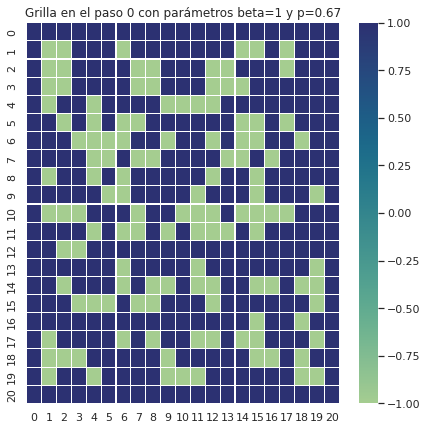

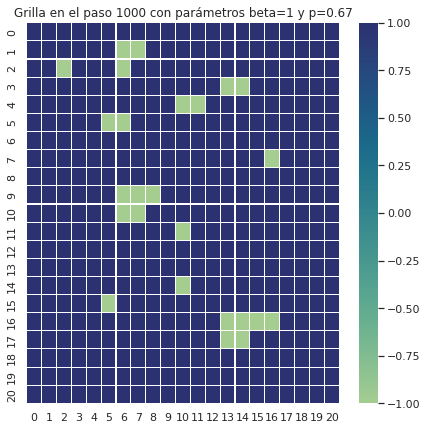

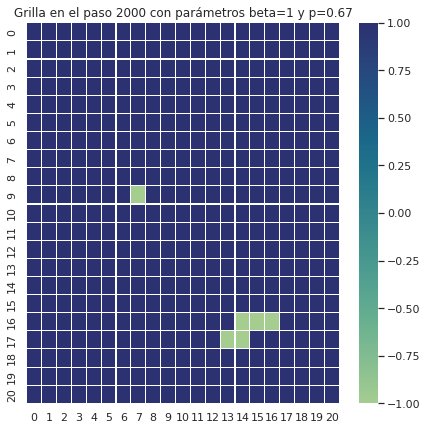

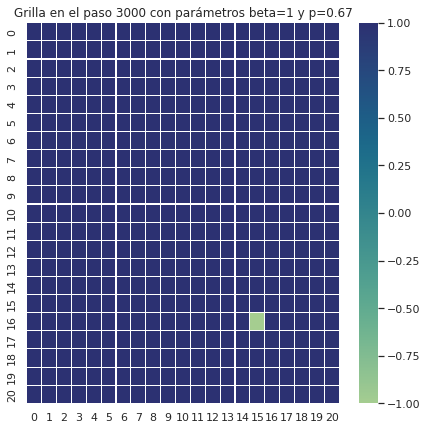

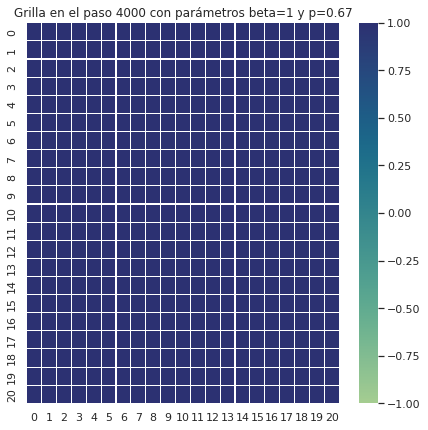

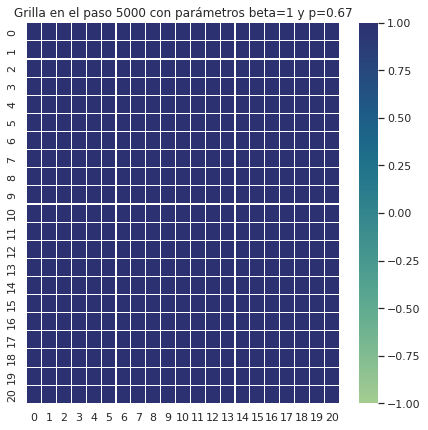

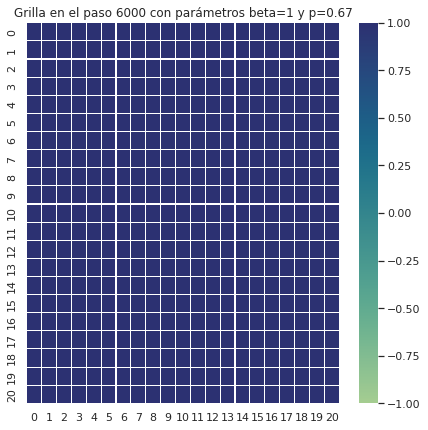

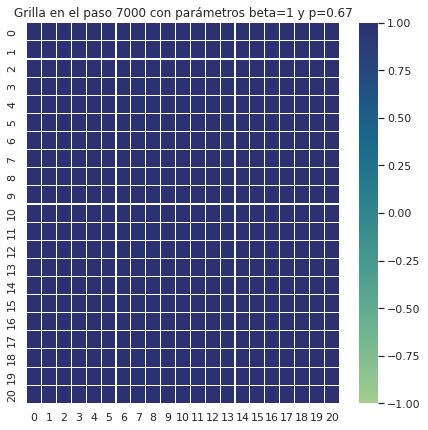

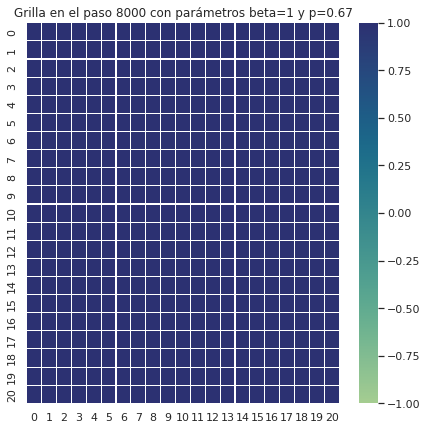

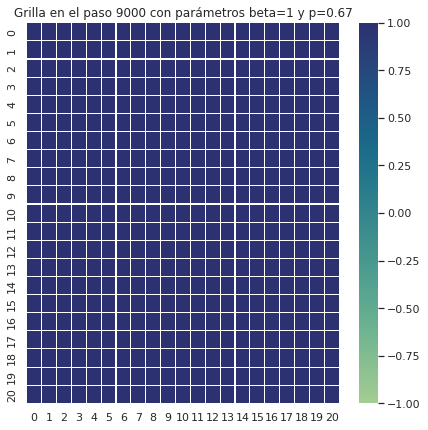

(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,


In [ ]:
# Caso con parametro sobre la distribucion Bernoulli de 2/3
Ising(10,1,10000,2/3,True)

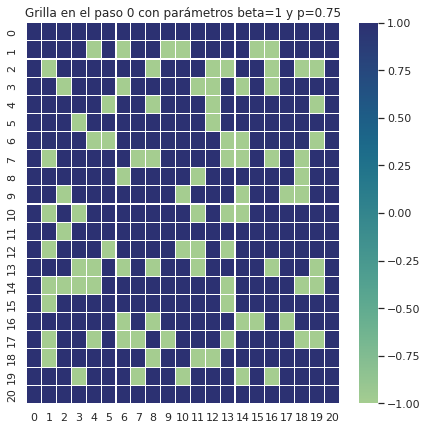

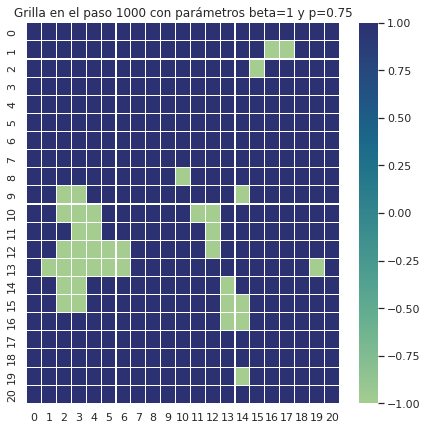

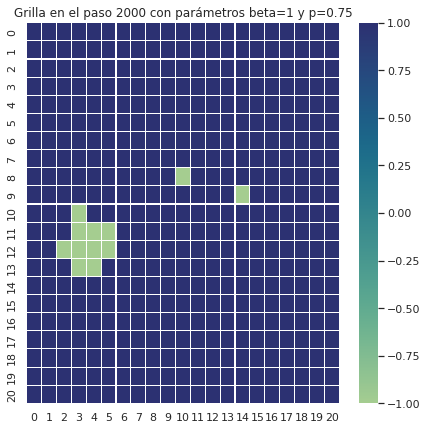

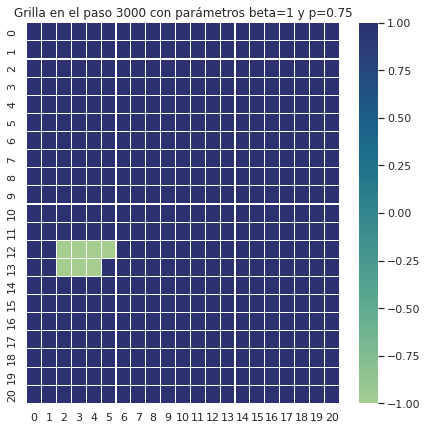

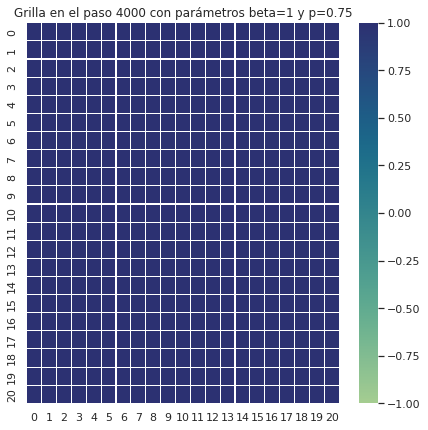

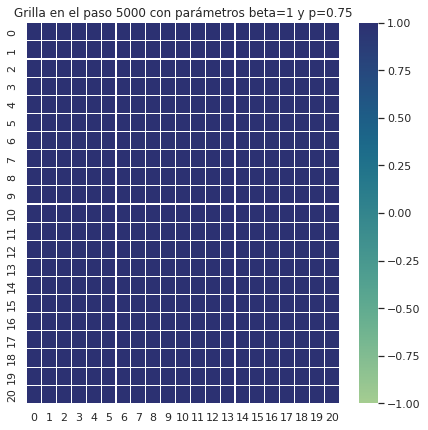

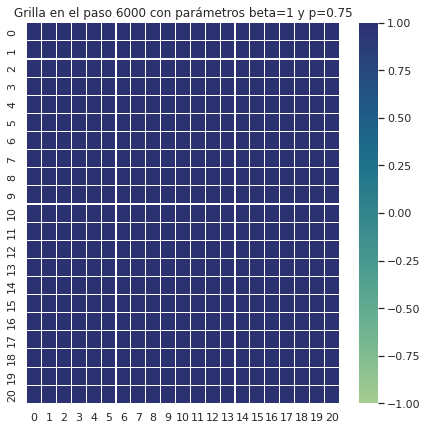

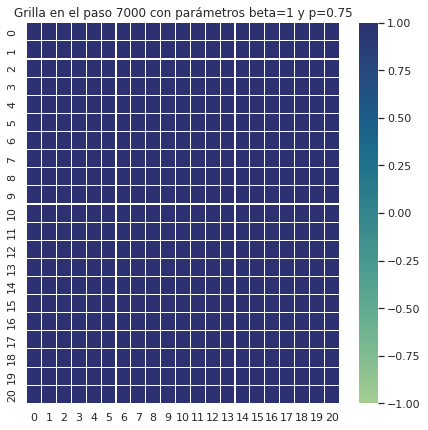

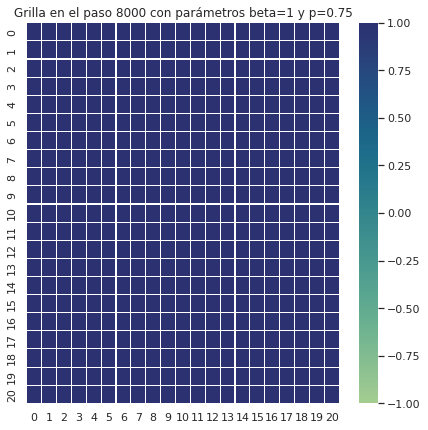

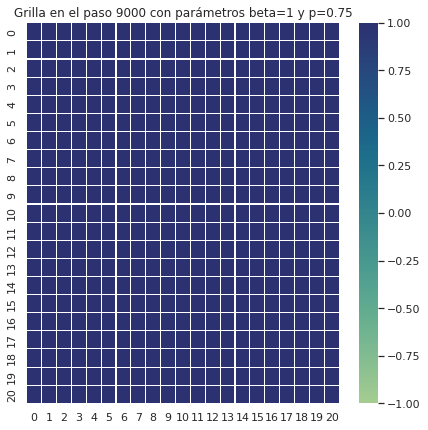

(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,


In [ ]:
# Caso con parametro sobre la distribucion Bernoulli de 3/4
Ising(10,1,10000,3/4,True)


**Comentarios:** En ambos casos no podemos distinguir un comportamiento diferente, podemos observar que ambos casos, considerando $\beta = 1$ en ambos sigue que el estado final observado el estado tiene todos los spins orientados hacia $1$.  De esto podemos inferir que la elección de $p$ no influye en la evolución de la cadena. A partir de esto es factible creer que el parámetro $\beta$ y las condiciones iniciales afectan de mayor forma la simulación. Veamos lo que ocurre considerando $\beta = 0.3$ para ambos casos de $p$ ya estudiados.

**Estudio de $p$ para $\beta = 0.3$ fijo:** Veamos a continuación la evolución del sistema considerando $p\in \left\{\frac{2}{3},\frac{3}{4}\right\}$ con $\beta = 0.3$ fijo.


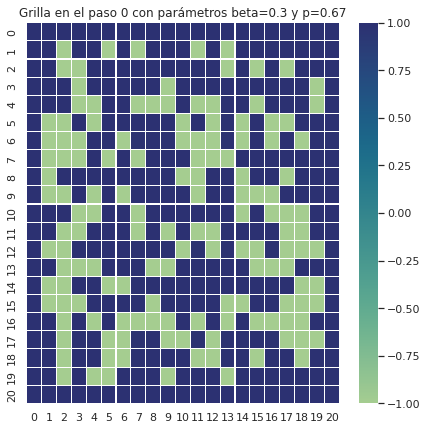

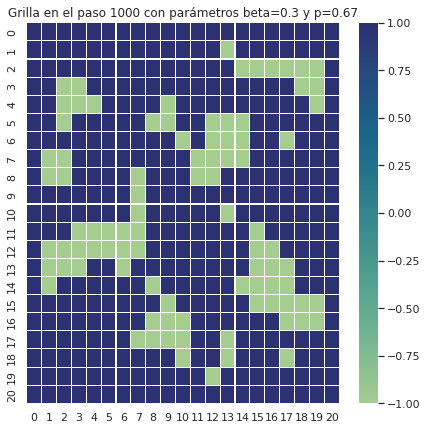

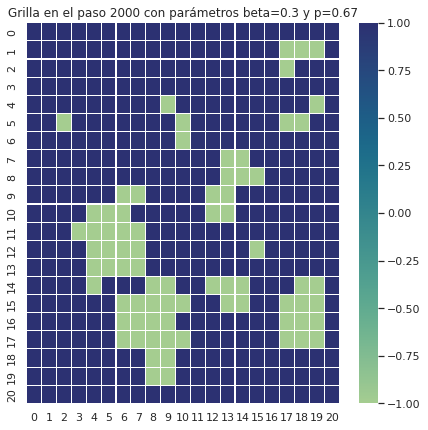

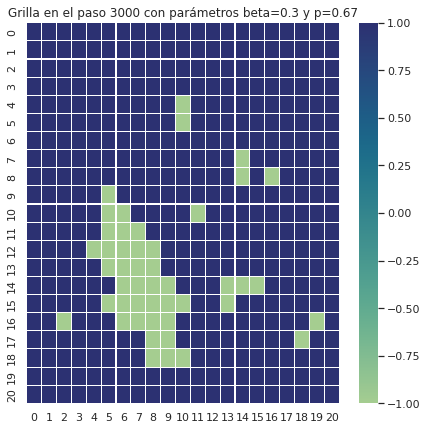

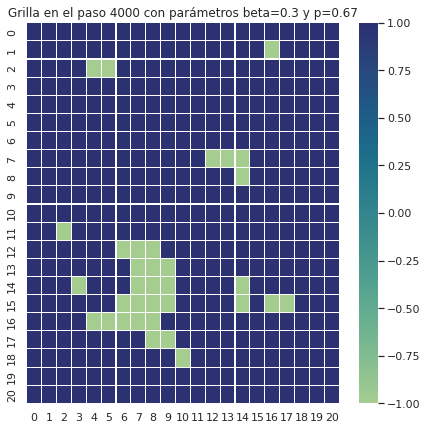

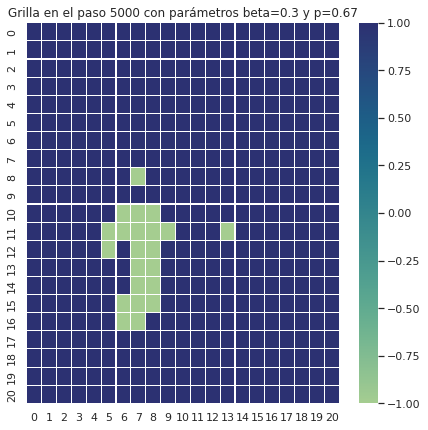

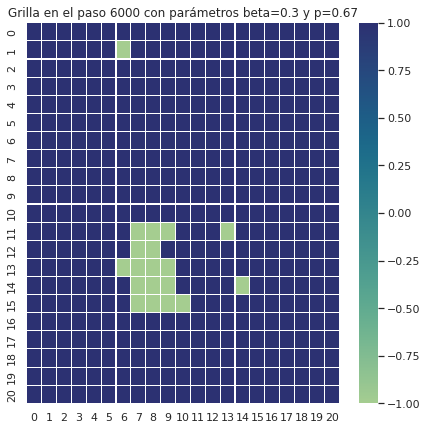

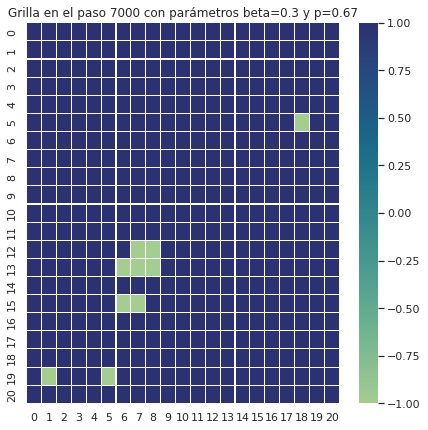

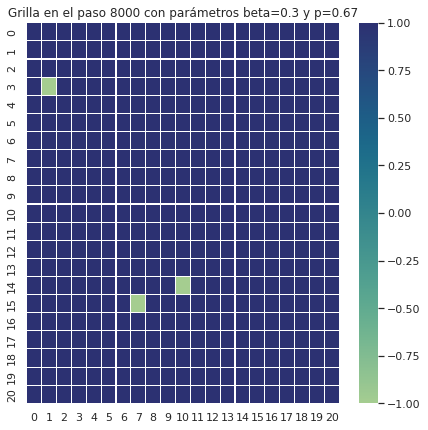

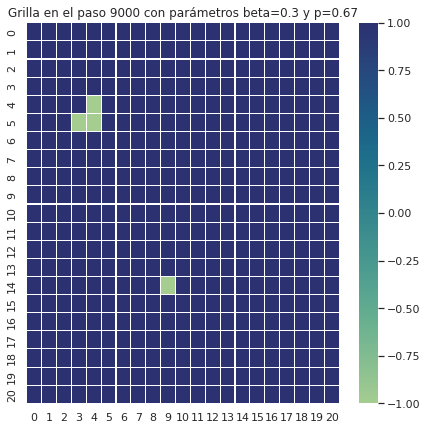

(array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        

In [ ]:
# Caso con parametro sobre la distribucion Bernoulli de 2/3
Ising(10,0.3,10000,2/3,True)

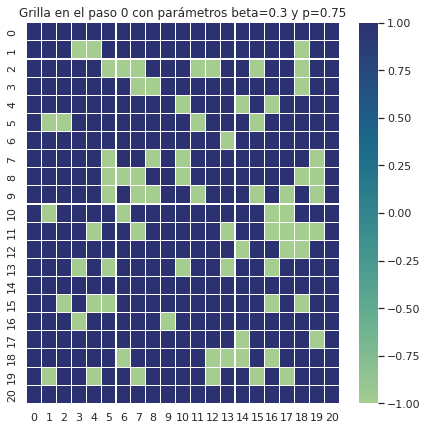

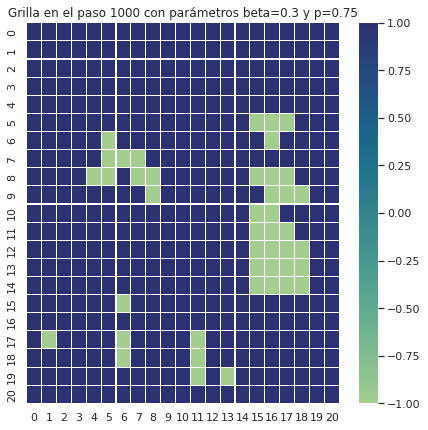

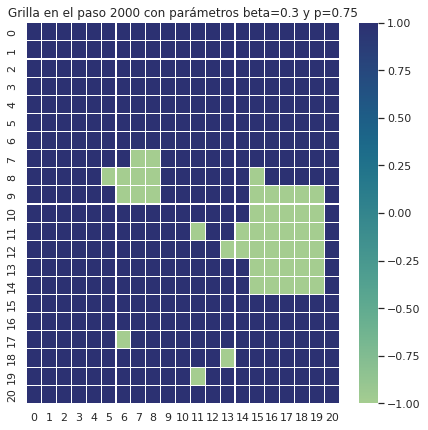

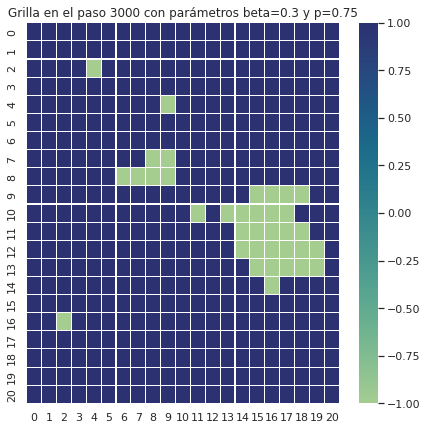

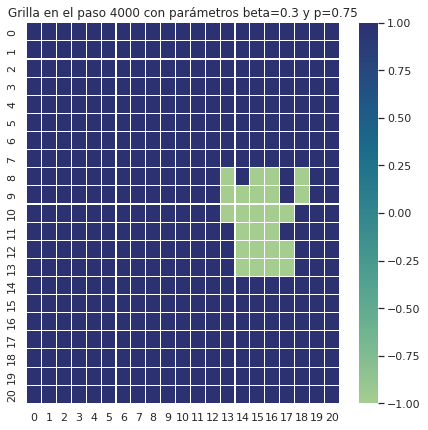

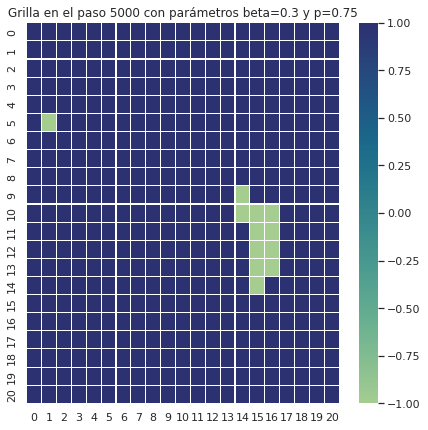

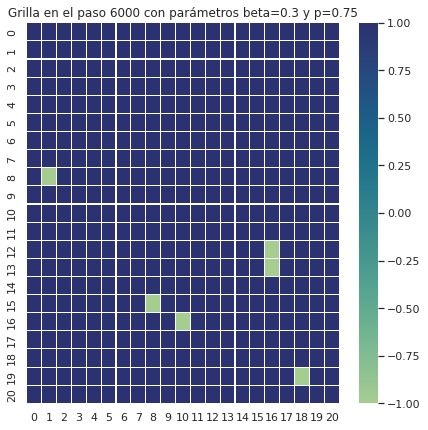

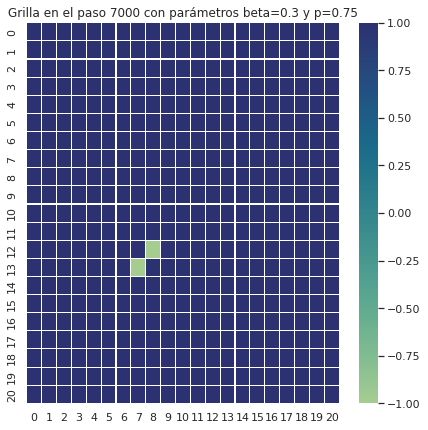

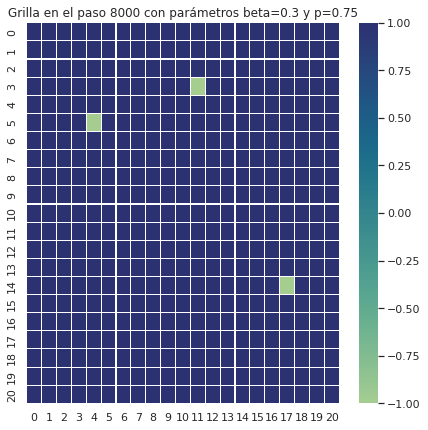

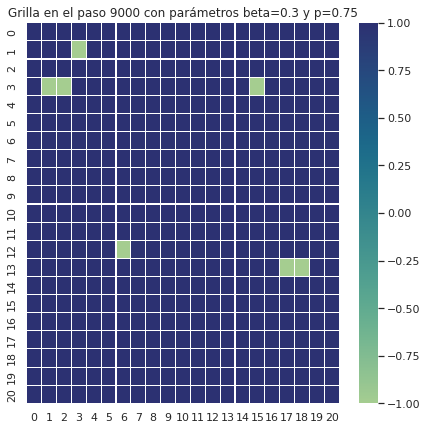

(array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        

In [ ]:
# Caso con parametro sobre la distribucion Bernoulli de 3/4
Ising(10,0.3,10000,3/4,True)

**Comentarios:** Nuevamente podemos observar que para $\beta$ fijo, ambos casos de $p$ obtienen resultados similares en el estado final. Sin embargo, al cambiar a $\beta = 0.3$ se observa que el estado final es diferente al obtenido para $\beta = 1.0$.


En lo que sigue veremos un analisis con mayor detalle sobre $\beta$.

---

## Parte 4
### Enunciado 
En lo que sigue, fije $N\in\{50,\dots,200\}$ (lo más frande que se puedam mientras la simulación sea fluida). Observe el comportamiento de la cadena en el tiempo largo para un $\beta$ pequeño y otro grande (digamos, escoja un $\beta < 0.1$ y otro $\beta > 5$). Grafique y comente.
### Solución
**Elección de valores:** Fijamos $N = 50$, $nf = 10^{6}$ y $p = 3/4$ para implementar el método *Ising* para los valores distintos de $\beta$. Elegimos
\begin{equation}
    \beta_{1} = 0.05 ,\quad \beta_{2} = 10.
\end{equation}

**$\beta$ grande:** A continuación presentamos el resultado.

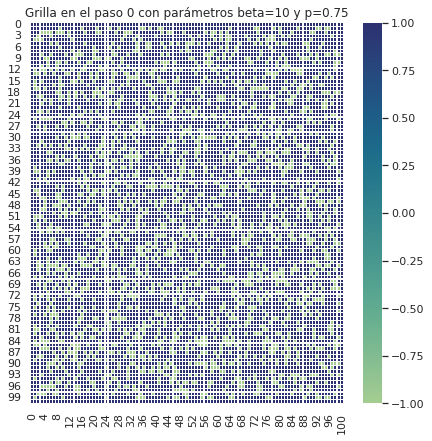

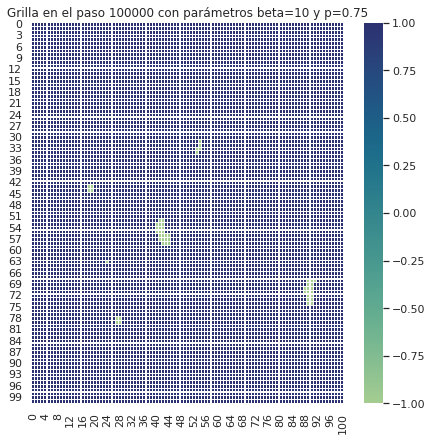

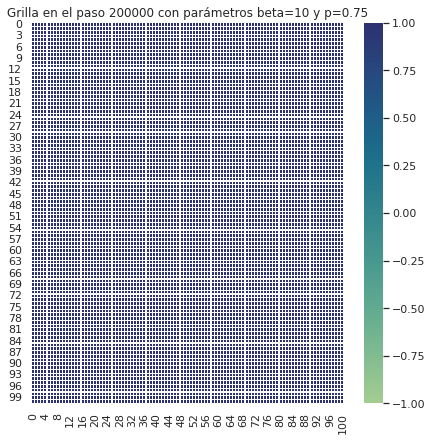

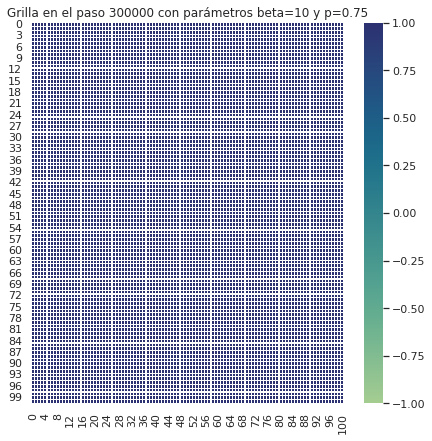

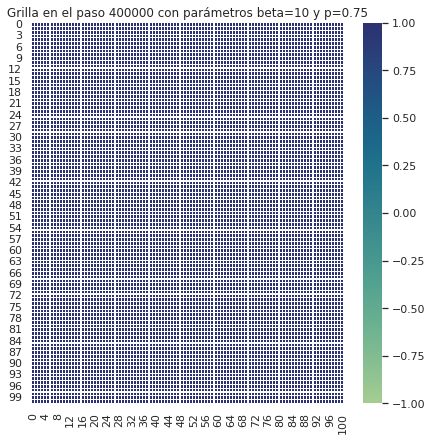

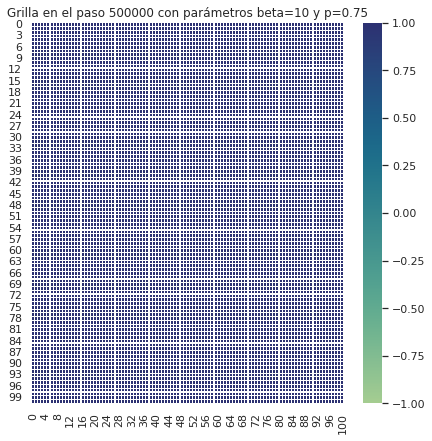

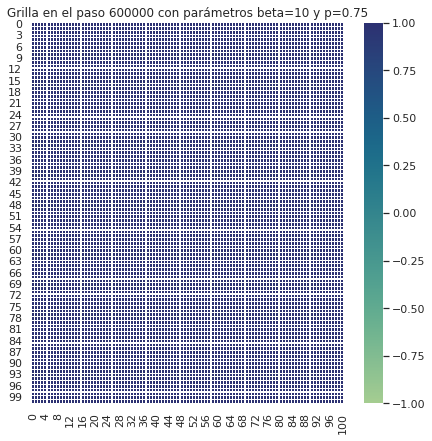

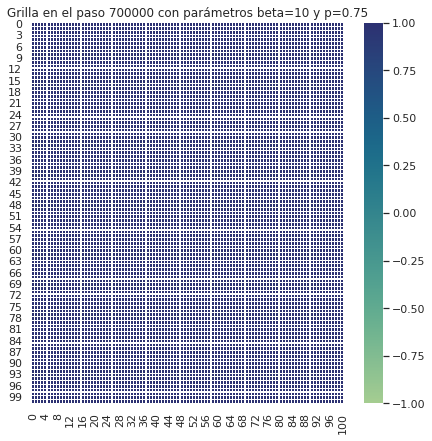

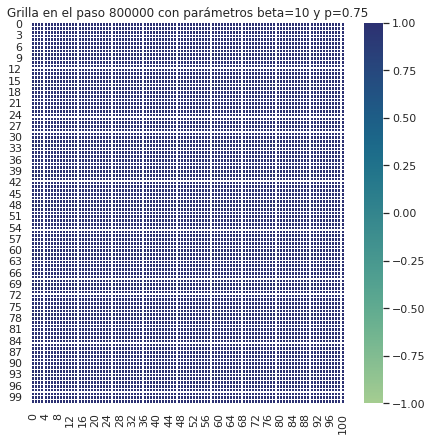

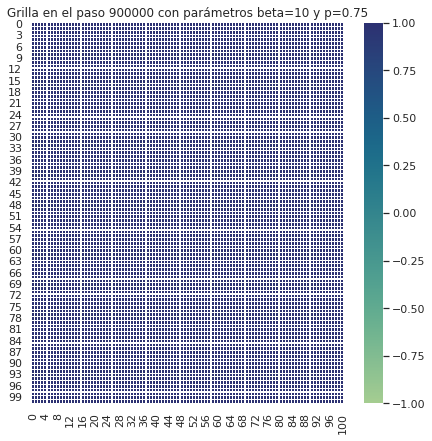

(array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]), 1.0)

In [ ]:
# beta grande
Ising(50,10,10**6,3/4,True)

En este caso con un mayor $\beta$ (y por lo tanto una menor temperatura), el sistema tiende a minimizar su energía y tener magnetización perfecta (todos los spins iguales) para una cantidad de pasos lo suficientemente grande. Esto es lo esperable del *principio de mínima acción* (un sistema físico en equilibrio busca minimizar su acción a partir de su Hamiltoniano), en este caso se desea buscar un equilibrio con la menor energía posible.

**$\beta$ pequeño:** A continuación presentamos el resultado para $\beta$ pequeño.

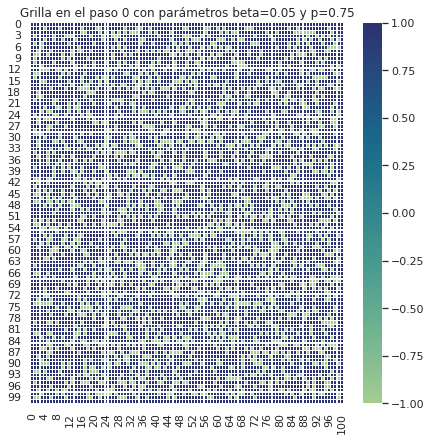

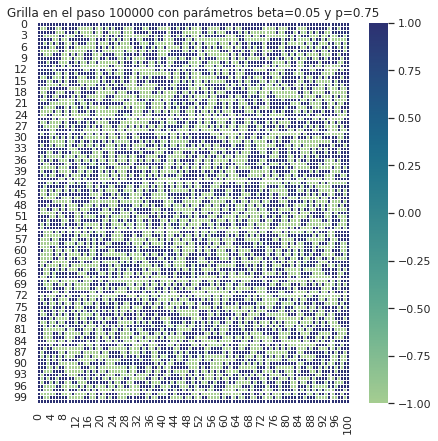

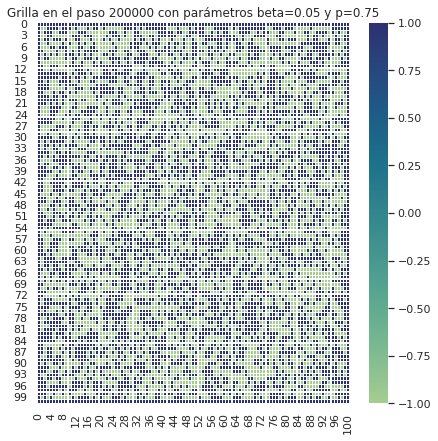

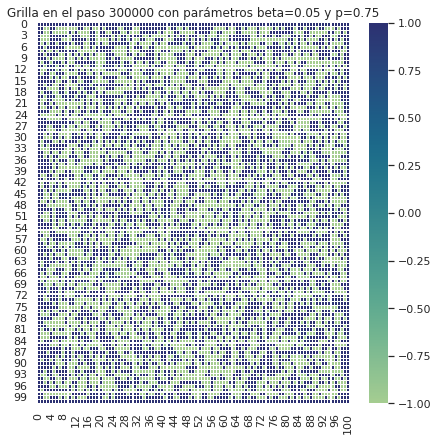

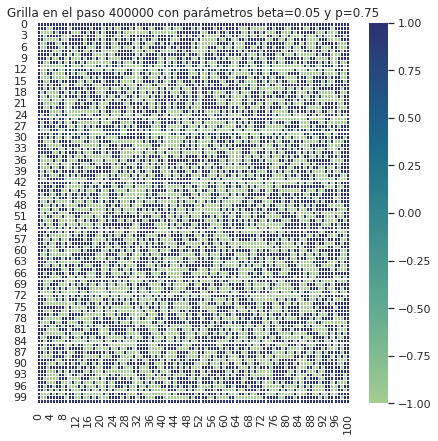

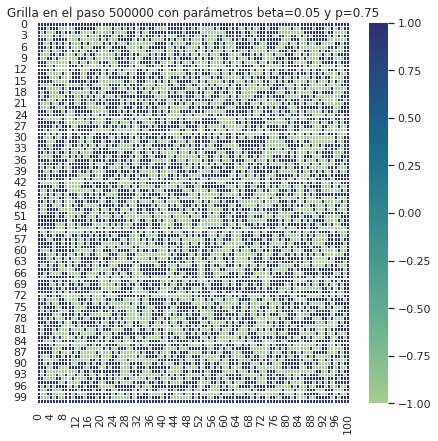

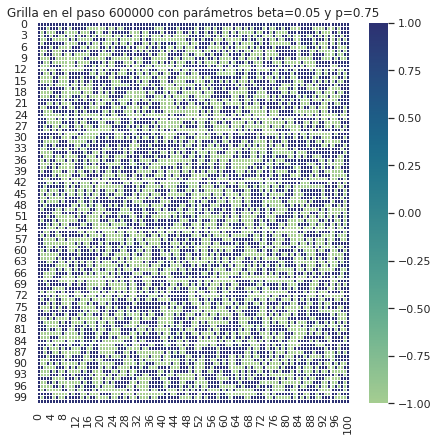

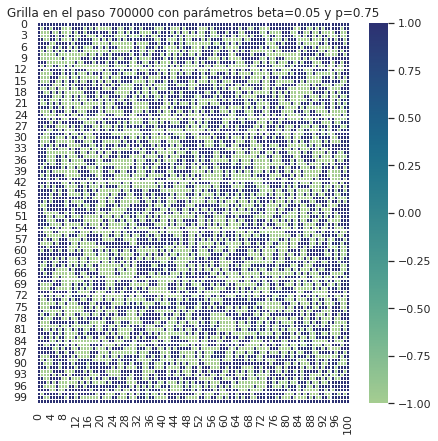

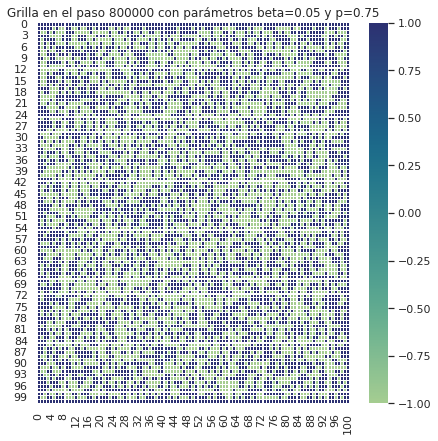

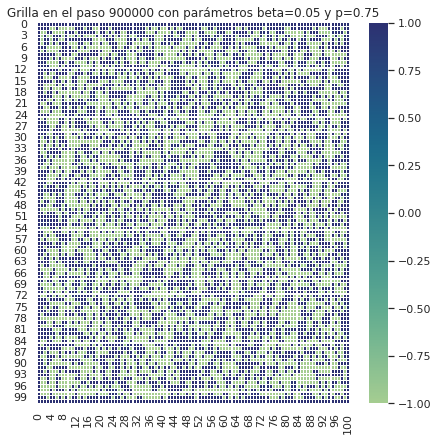

(array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1., -1.,  1., ..., -1., -1.,  1.],
        ...,
        [ 1.,  1., -1., ...,  1.,  1.,  1.],
        [ 1., -1.,  1., ..., -1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]), 0.037153220272522304)

In [ ]:
# beta pequeño
Ising(50,0.05,10**6,3/4,True)

Notemos que en este caso conviven ambos estados, esto es, conviven spins orientados hacia $1$ y hacia $-1$, el sistema presenta la coexistencia de estados pero aún así tiende a minimizar su energía de forma local, haciendo zoom podemos ver que hay zonas con estado uniforme (ver figura a continuación) 

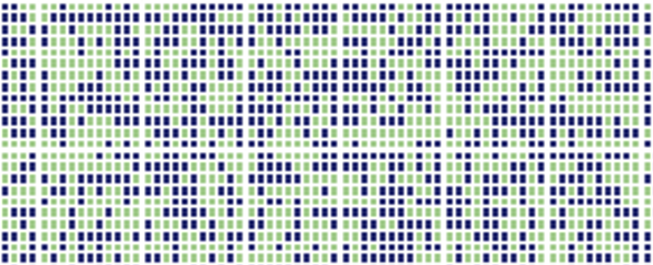

Notemos que pese a que conviven ambos estados, localmente hay regiones donde hay uniformidad en los estados, este fenómeno corresponde al *ferromagnetismo* obteniendo materiales que internamente presentan distintos *dominios magnéticos*. Esto luce como

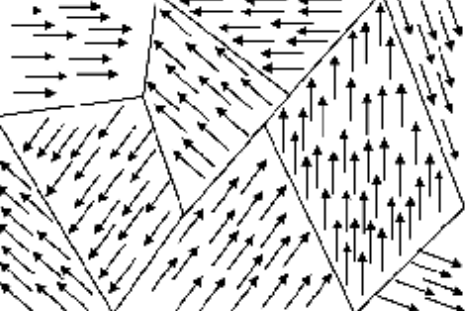

Cane mencionar que un medio como en el caso (1) (con $\beta$ grande) hay *un dominio magnético*, estos materiales (como los imanes) corresponde a un medio magnético (estudiados en electromagnetismo clásico). 

Una pregunta interesante sobre este *modelo de Ising* es:

**¿Qué ocurre con $\beta$ negativo?** Considerando $\beta = -1$ tenemos el siguiente resultado:

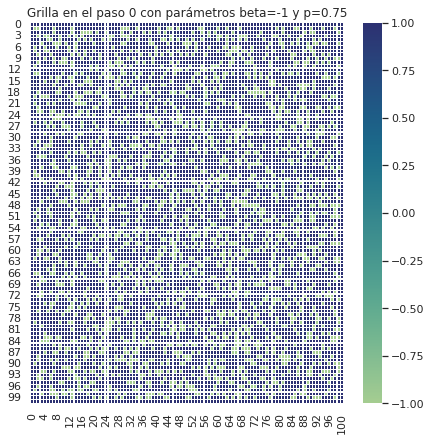

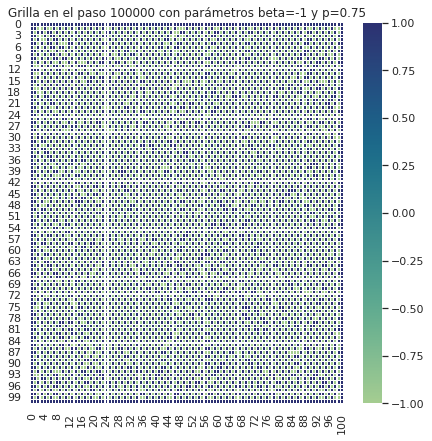

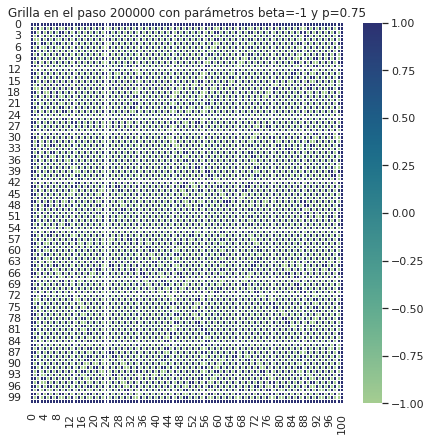

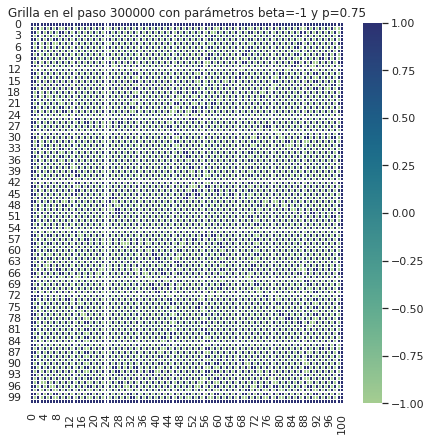

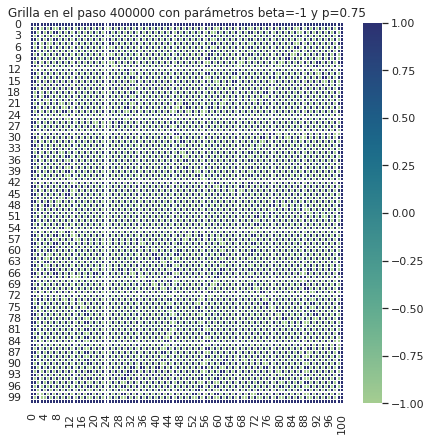

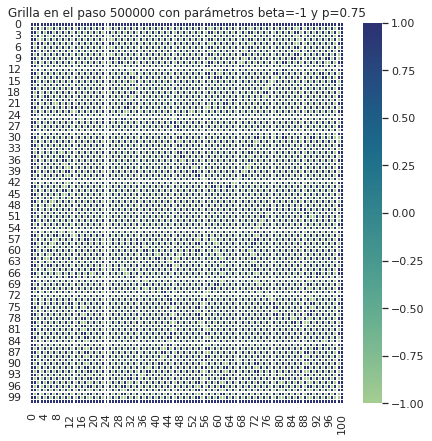

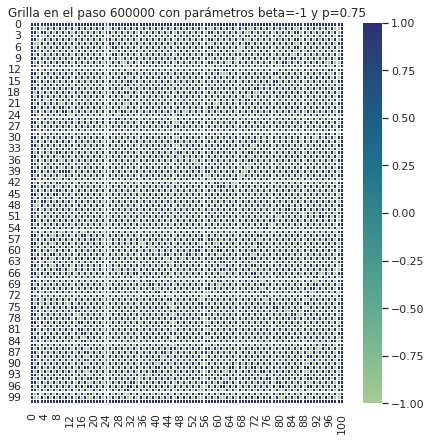

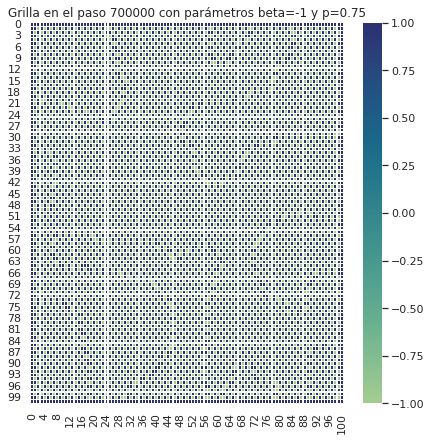

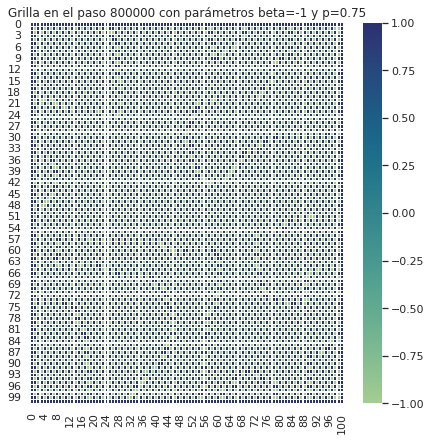

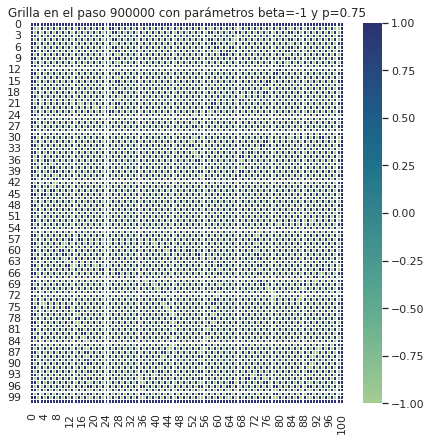

(array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1., -1., -1., ..., -1., -1.,  1.],
        [ 1., -1.,  1., ...,  1., -1.,  1.],
        ...,
        [ 1., -1.,  1., ...,  1., -1.,  1.],
        [ 1.,  1., -1., ..., -1., -1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]), 0.037741397902166456)

In [ ]:
# beta negativo
Ising(50,-1,10**6,3/4,True)

En este caso observamos que los spins adyacentes tienden a intercalar su orientación, esto trae como consecuencia una maximización de la energía $H$. Este fenómeno que tiene una interpretación física se conoce como *antiferromagnetismo* (no hay *dominios magnéticos*). Una propuesta para estudiar esto es ver cómo se relaciona la energía $H$ y la entropía posiblemente añadiendo una corrección sobre la expresión $H$.

**Comentario sobre $\beta$:** Notamos que para $\beta$ grande, esto es, una baja temperatura el medio tiende a magnetizarse, esto es que el medio orienta todos los spins de igual manera y dada que la condición de borde es que los spins de $\partial\Lambda$  toman la orientación $1$ en este caso la totalidad del medio se orienta según $1$. 

Por otro lado, para $\beta$ pequeño hay que notar que pueden convivir spins distintos en un mismo estado $x$. La pregunta natural es *¿es posible obtener el $\beta$ para el cual se tiene la transición entre ambas características vistas antes?*, esto lo estudiaremos en el siguiente problema.

---

Lo observado en el punto anterior se conoce como *transición de fase*: Existe un valor crítico $\beta_{C} > 0$ tal que para cualquier $\beta > \beta_{C}$ y $N$ grande, $\pi$ asigna probabilidad casi $1$ a configuraciones con spin hacia rriba en la gran mayoría de los sitios (con la condición de borde que usamos), mientras que cuando $\beta < \beta_{C}$ se observa la coexistencia de ambos spins. A continuación estudiaremos este fenómeno.

## Parte 5
### Enunciado
Fije *nf* grande (en el orden de los millones), de modo que el algoritmo tenga tiempo de acercarse a $\pi$ (distribución invariante). Fije una malla del intervalo $[0,1]$ de distintos valores de $\beta$. Para cada $\beta$ en la malla, obtenga el estado $X$ de la cadena luego de *nf* pasos, y calcule el *spin* medio $\displaystyle s = \frac{1}{|\Lambda|}\sum_{m\in\Lambda}X(m)$. Grafique $s$ en función de $\beta$, y estime visualmente el valor crítico $\beta_{C}$.

### Solución
Para esta parte realizamos el cálculo del promedio simple de los spins para distintos valores de $\beta \in (0,1)$. Los resultados se muestran en la siguiente figura.

In [ ]:
def GraficarSpinMedio(beta,spin):
    """=========================================================================
    INPUT: El metodo recibe los siguientes parametros
    N = una arreglo con distintos parametros de beta
    p = un arreglo de distintos spin medios
    ---
    OUTPUT: Nada
    ---
    COMENTARIOS: Al ejecutarse el metodo entrega una figura del spin medio en
    funcion de beta
    ========================================================================="""
    plt.figure(figsize=(20,6))
    plt.plot(beta,spin,'red')
    plt.xlabel('Beta')
    plt.ylabel('Spin medio')
    plt.axvline(x=0.4,color='g',linestyle='dashed')
    plt.axvline(x=0.5,color='b',linestyle='dashed')
    plt.axhline(y=1.0,color='r',linestyle='dashed')
    plt.legend(['Spin medio en función de beta','Beta = 0.4','Beta = 0.5','Spin medio = 1.0'])
    plt.title('Spin medio en función de beta')
    plt.grid()

In [ ]:
# Calculo del spin medio en funcion de beta para distintos betas en (0,1)
N=50;nf=10**6;p=3/4                     
beta = np.linspace(0.0001,1,100)
spin = np.zeros(len(beta))
for i in range(len(beta)):
    spin[i] = Ising(N,beta[i],nf,p)[1]

En la siguiente figura observamos el spin medio en función de beta.

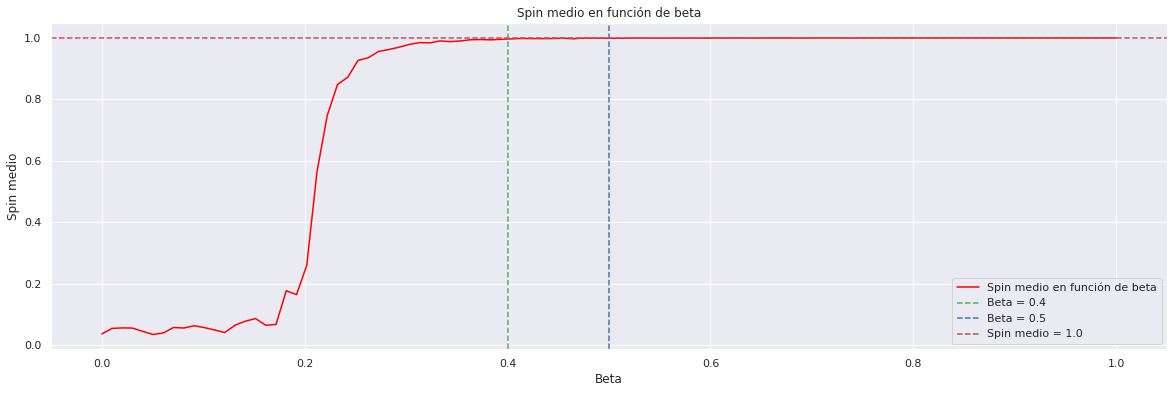

In [ ]:
GraficarSpinMedio(beta,spin)

Podemos notar que la curva (en rojo) del spin medio alcanza el valor de $1$ en el intervalo $(0.4;0.5)$. Por lo que para hallar $\beta_{C}$ a continuación nos enfocamos en estudiar este intervalo.

---

## Parte 6
### Enunciado
Repita lo anterior en un intervalo más pequeño centrado en su estimación de $\beta_{C}$, y con *nf* más grande aún, de modo de obtener una estimación más fina. Grafique. Averigüe el valor exacto de $\beta_{C}$ y compárelo con su estimación.
### Solución
Para realizar un análisis más fino, antes veamos la siguiente tabla en torno a $\beta = 0.47$ en donde se indica el spin medio. En cuyo caso consideraremos que $0.999 \approx 1$ recién con $3$ cifras decimales. Bajo este criterio podemos nota que en $\beta\in(0.46;0.47)$ recién hay un acercamiento mayor al spin medio $s = 1$.

In [ ]:
datos_de_la_tabla = {'Valor de beta': [
                                '0.440', 
                                '0.450', 
                                '0.460', 
                                '0.470',
                                '0.480',
                                '0.490',
                                '0.500'
                                ],
                     'Spin medio':[
                                    Ising(50,0.440,10**6,3/4)[1],
                                    Ising(50,0.450,10**6,3/4)[1],
                                    Ising(50,0.460,10**6,3/4)[1],
                                    Ising(50,0.470,10**6,3/4)[1],
                                    Ising(50,0.480,10**6,3/4)[1],
                                    Ising(50,0.490,10**6,3/4)[1],
                                    Ising(50,0.500,10**6,3/4)[1]
                                   ]}
pd.DataFrame.from_dict(datos_de_la_tabla)

,Valor de beta,Spin medio
0,0.440,0.998824
1,0.450,0.997451
2,0.460,0.998235
3,0.470,0.999020
4,0.480,0.999216
5,0.490,0.998824
6,0.500,0.999412


Para estudiar localmente el comportamiento de $s(\beta)$ modificamos el método *GraficarSpinMedio*, tal que nos permita ver con más certeza una región de interés.

In [ ]:
def GraficarSpinMedioFinoConZoom(beta,spin,xinf,xsup,yinf=0.98,ysup=1.01):
    """=========================================================================
    INPUT: El metodo recibe los siguientes parametros
    N = una arreglo con distintos parametros de beta
    p = un arreglo de distintos spin medios
    xinf = cota inferior para x
    xsup = cota superior para x
    yinf = cota inferior para y
    ysup = cota superior para y 
    ---
    OUTPUT: Nada
    ---
    COMENTARIOS: Al ejecutarse el metodo entrega una figura del spin medio en
    funcion de beta. El metodo es igual que *GraficarSpinMedio*, con la salvedad
    de que se puede controlar la region en la cual se observa la curva, lo que
    sirve para realizar zoom
    ========================================================================="""
    plt.figure(figsize=(20,6))
    plt.plot(beta,spin,'red')
    plt.axvline(x=0.475,color='b',linestyle='dashed')       # Beta critico
    plt.axhline(y=1,color='r',linestyle='dashed')           # Spin medio = 1
    plt.ylim(yinf,ysup)
    plt.xlim(xinf,xsup)
    plt.legend(['Spin medio en función de beta','Beta_{C} = 0.475','Spin medio = 1.0'])
    plt.xlabel('Beta')
    plt.ylabel('Spin medio')
    plt.title('Spin medio en función de beta (con zoom)')
    plt.grid()

In [ ]:
N=50;nf=10**7;p=3/4
beta2 = np.linspace(0.4,0.5,20)
spin2 = np.zeros(len(beta2))
for i in range(len(beta2)):
    spin2[i] = Ising(N,beta2[i],nf,p)[1]

A continuación estudiamos la región $(0.46-\varepsilon;0.47+\varepsilon)$

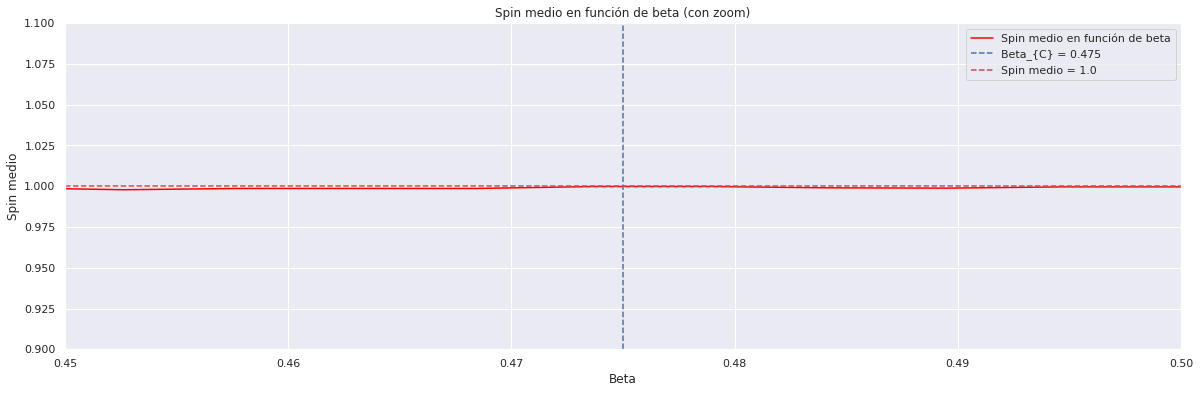

In [ ]:
GraficarSpinMedioFinoConZoom(beta2,spin2, 0.45, 0.5, 0.9, 1.1)

Según la recta azul se tiene que $\beta_{C} = 0.475$ en la cual la curva de *spin medio en función de beta* intersecta con la recta *spin medio = 1.0*. Esto quiere decir que para $\beta > \beta_{C}$ encontrado, para el *modelo de Ising* resulta que el sistema para *nf* suficientemente alto tenderá al estado en que todos los spins se orientan hacia $1$. 

Veamos la continuación un modelo de Ising para $\beta_{C}$ hallado antes. Se espera que sea posible observar muy pocas zonas con spin orientados hacia $-1$, sin embargo estas deben ser mínimas (un par aislado de celdas de la grilla).

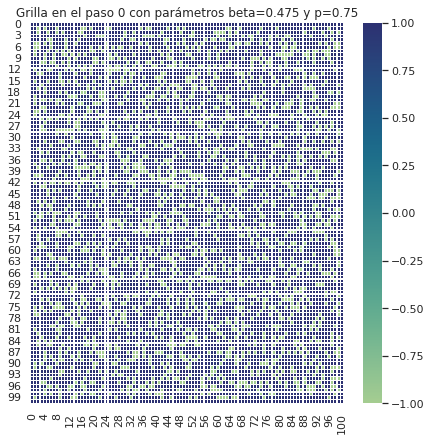

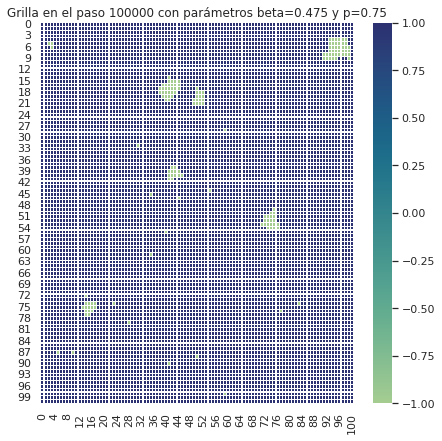

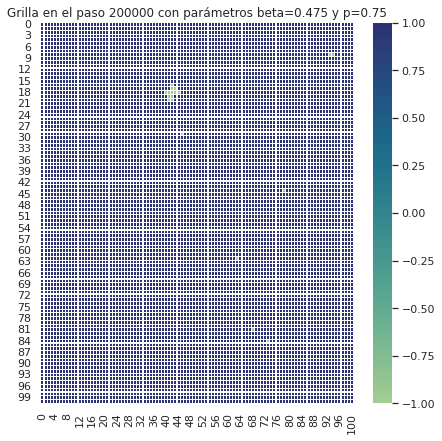

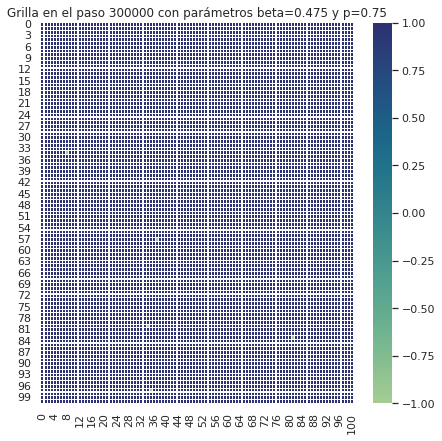

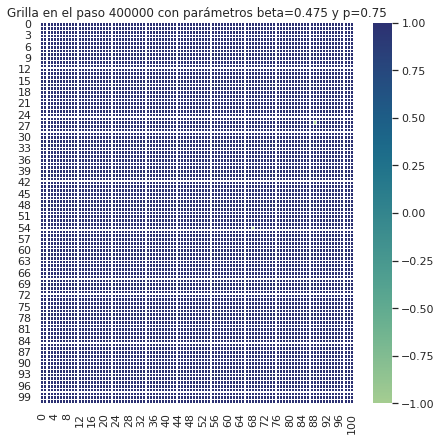

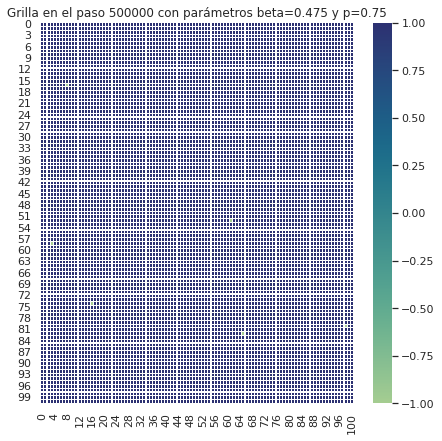

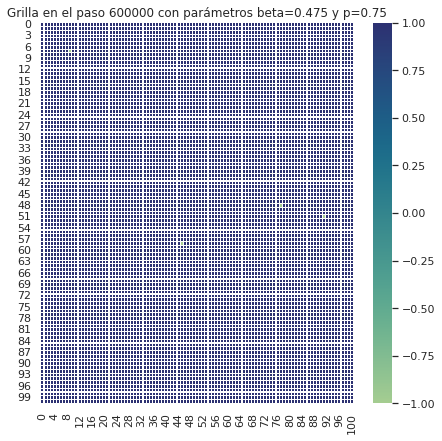

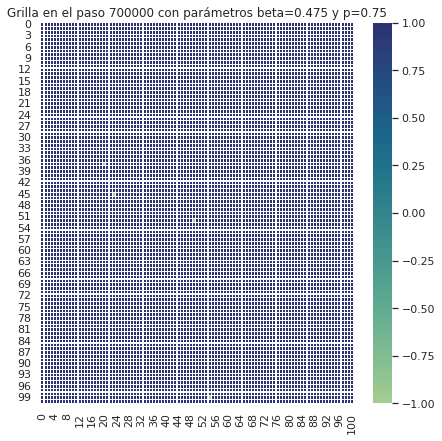

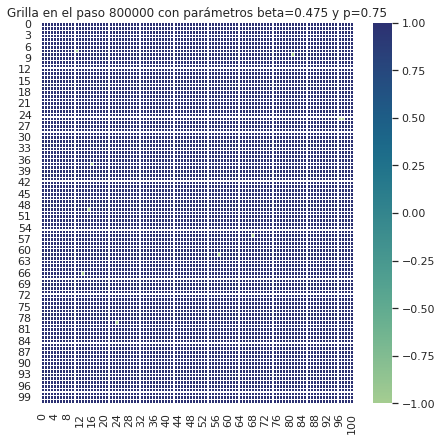

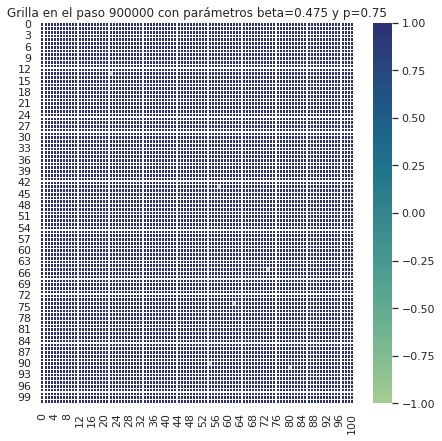

(array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]), 0.9992157631604744)

In [ ]:
# beta critico
Ising(50,0.475,10**6,3/4,True)

Por lo observado antes, se aprecia (haciendo un zoom simple) que hay celdas orientadas hacia $-1$, sin embargo predomina la orientación hacia $1$ en gran parte de la grilla. De lo que podemos concluir que nuestra estimación de $\beta_{C}$ es correcta.